In [50]:
# Import required liabraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error


In [2]:
train_df=pd.read_csv('train.csv')
store_df=pd.read_csv('store.csv')
df=pd.merge(store_df,train_df,on='Store')


In [3]:
df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,5,2015-07-31,5263,555,1,1,0,1
1,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,4,2015-07-30,5020,546,1,1,0,1
2,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,3,2015-07-29,4782,523,1,1,0,1
3,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2,2015-07-28,5011,560,1,1,0,1
4,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,1,2015-07-27,6102,612,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",6,2013-01-05,4771,339,1,0,0,1
1017205,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",5,2013-01-04,4540,326,1,0,0,1
1017206,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",4,2013-01-03,4297,300,1,0,0,1
1017207,1115,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",3,2013-01-02,3697,305,1,0,0,1


In [4]:
df.update(df["Promo2SinceWeek"].fillna(value=0,inplace=True))
df.update(df["Promo2SinceYear"].fillna(value=0,inplace=True))
df.update(df["PromoInterval"].fillna(value=0,inplace=True))
mean_CompetitionDistance=df["CompetitionDistance"].mean()
df.update(df['CompetitionDistance'].fillna(value=mean_CompetitionDistance,inplace=True))

In [5]:
# Fillig CompetitionOpenSinceMonth, CompetitionSinceYear with most occurig month  and year respectively
mode_CompetitionOpenSinceMonth=df['CompetitionOpenSinceMonth'].mode()[0]
mode_CompetitionOpenSienceYear=df['CompetitionOpenSinceYear'].mode()[0]
df.update(df['CompetitionOpenSinceMonth'].fillna(value=mode_CompetitionOpenSinceMonth,inplace=True))
df.update(df['CompetitionOpenSinceYear'].fillna(value=mode_CompetitionOpenSienceYear,inplace=True))
df.isnull().sum()

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
dtype: int64

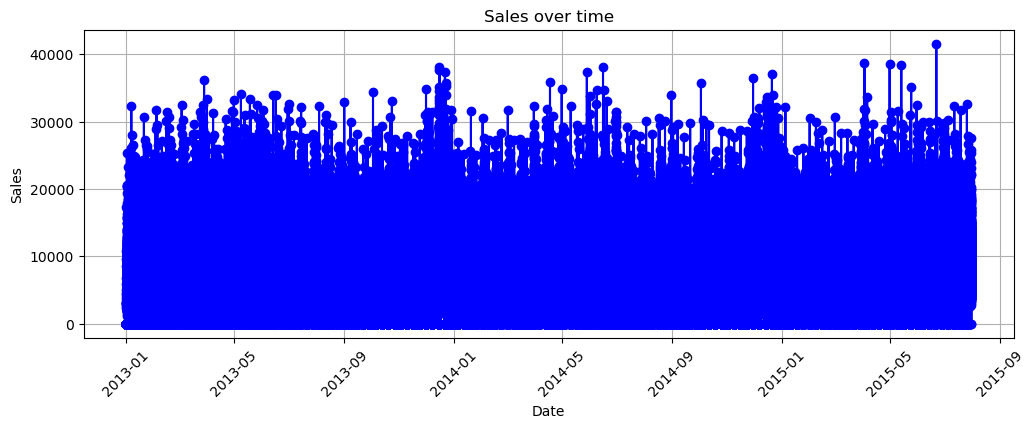

In [6]:
# Convert the Date column value to Datetime column type
df['Date']=pd.to_datetime(df['Date'])
df.sort_values(by='Date',inplace=True)
# Plot the sales over time
plt.figure(figsize=(12,4))
plt.plot(df['Date'],df['Sales'],color='blue',marker='o',linestyle='-')
plt.title('Sales over time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

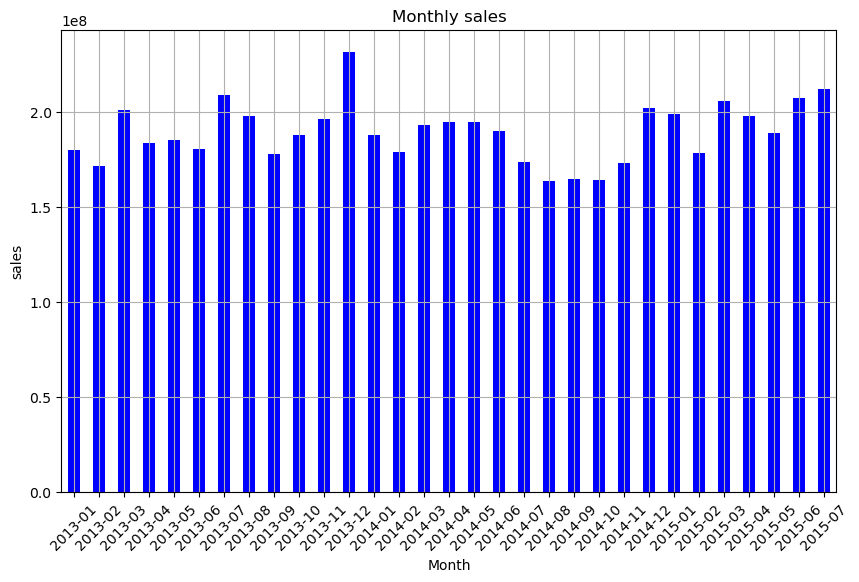

In [7]:
# Monthly sales plotting
# Extracting month and year from the datecolumn 
df['Year_month']=df['Date'].dt.to_period('M')
monthly_sales=df.groupby('Year_month')['Sales'].sum()
# Plotting  the sales over the months 
plt.figure(figsize=(10,6))
monthly_sales.plot(kind='bar',color='blue')
plt.title('Monthly sales')
plt.xlabel('Month')
plt.ylabel('sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

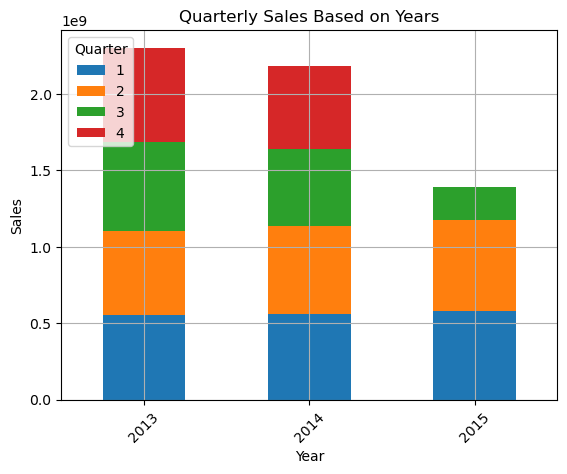

In [9]:
# Extracting year and quarter from the date column
df['Year'] = df['Date'].dt.year
df['Quarter'] = df['Date'].dt.quarter

# Grouping by 'Year' and 'Quarter' to get the sum of 'Sales'
quaterly_sales = df.groupby(['Year', 'Quarter'])['Sales'].sum()

# Plotting
plt.figure(figsize=(10, 6))
quaterly_sales.unstack().plot(kind='bar', stacked=True)
plt.title('Quarterly Sales Based on Years')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Quarter', loc='upper left')
plt.show()

In [13]:
#x=df['Sales'].values
#reslut=adfuller(x)
#print('ADF statistics : %f' %result[0])
#print('p-value:%f'%result[1])
#print('critical values')
#for key,vlaue in result[4].items():
#   print('\t%s: %.3f'%(key,value))
#if result[0]<result[4]["5%"]:
#    print("Reject Ho -Time series is stationary")
#else:
#    print('falied to Reject Ho -time series is not stationary')

# ACF

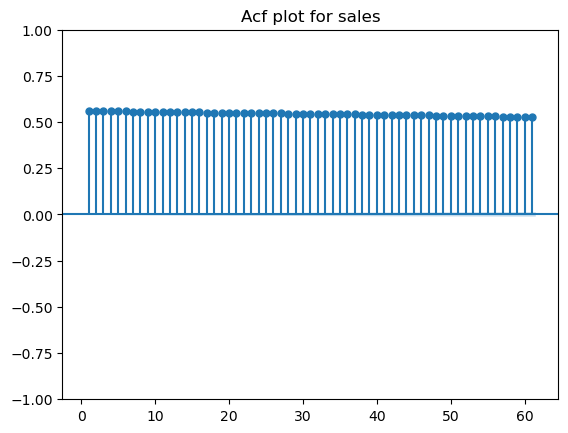

In [58]:
acf_plot=plot_acf(df['Sales'],title='Acf plot for sales',zero=False)

# PACF 

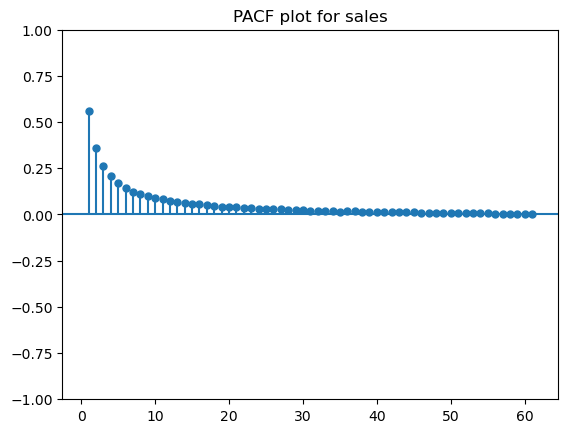

In [60]:
pacf_plot = plot_pacf(df['Sales'], title='PACF plot for sales', zero=False)

In [20]:
def create_supervised_data(data, lag=1):
    # Create a DataFrame from the original data
    df = pd.DataFrame(data)
    
    # Generate lag features for the specified number of lags
    for i in range(1, lag + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)
    
    # Replace NaN values with 0
    df.fillna(0, inplace=True)
    
    return df

# Example usage
lag = 3  # Number of lag features to create
supervised_data = create_supervised_data(df['Sales'], lag=lag)


In [22]:
supervised_data

,Sales,lag_1,lag_2,lag_3
1017208,0,0.0,0.0,0.0
679363,0,0.0,0.0,0.0
155193,0,0.0,0.0,0.0
632403,0,0.0,0.0,0.0
361623,0,0.0,0.0,0.0
...,...,...,...,...
557530,8161,6778.0,10483.0,10156.0
212332,6756,8161.0,6778.0,10483.0
982701,9732,6756.0,8161.0,6778.0
769288,5151,9732.0,6756.0,8161.0


In [24]:
# Scale the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(supervised_data)

In [26]:
# Split data into training and testing sets
X = scaled_data[:, :-1]
y = scaled_data[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Reshape data for LSTM input
X_train=X_train.reshape((X_train.shape[0],1,X_train.shape[1]))
X_test=X_test.reshape((X_test.shape[0],1,X_test.shape[1]))


In [34]:
# Build LSTM model
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


In [40]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=5, monitor='val_loss')

In [42]:
# Train the mode
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 11s 401us/step - loss: 0.0234 - val_loss: 0.0180
Epoch 2/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 399us/step - loss: 0.0179 - val_loss: 0.0180
Epoch 3/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 399us/step - loss: 0.0179 - val_loss: 0.0177
Epoch 4/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 406us/step - loss: 0.0177 - val_loss: 0.0177
Epoch 5/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 397us/step - loss: 0.0178 - val_loss: 0.0177
Epoch 6/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 394us/step - loss: 0.0176 - val_loss: 0.0176
Epoch 7/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 407us/step - loss: 0.0176 - val_loss: 0.0184
Epoch 8/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 404us/step - loss: 0.0177 - val_loss: 0.0176
Epoch 9/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 404us/step - loss: 0.0177 - val_loss: 0.0176
Epoch 10/10
25431/25431 ━━━━━━━━━━━━━━━━━━━━ 10s 394us/step - loss: 0.0176 - val_loss: 0.0176


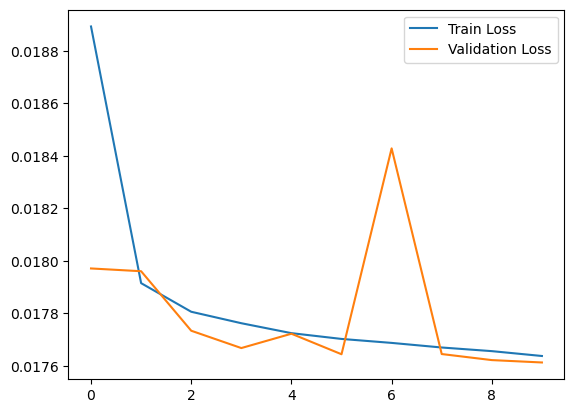

In [44]:

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

6358/6358 ━━━━━━━━━━━━━━━━━━━━ 1s 208us/step
Mean Squared Error: 0.017612260393065394
